1. NEON站点信息
站点代码：BART
全称：Bartlett Experimental Forest
位置：新罕布什尔州白山国家森林
NEON域：D01（Northeast Domain）
2. 可用的NEON数据产品
Bartlett（BART）作为NEON核心站点，拥有与Harvard Forest（HARV）类似的丰富数据，包括：
Vegetation Structure（DP1.10098.001）：树高、胸径、树种、mapping、biomass估算等
Woody Plant Aboveground Biomass（DP1.10100.001）
AOP遥感产品：包括高分辨率LiDAR、CHM、DTM、DSM、AOP生物量等
土壤、气象、微生物、昆虫等多种生态数据
3. 数据质量与应用
数据质量高：BART是NEON的核心站点，数据采集频率高，质量控制严格。
空间分辨率高：AOP产品分辨率可达1米，地面调查数据详细。
适合多种生态、遥感、机器学习等研究，与Harvard Forest一样，是美国森林生态学和遥感研究的热点区域。

In [1]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
from IPython.display import HTML
import contextily as ctx
import matplotlib.pyplot as plt
import folium
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
import math
import random
from rasterio.transform import from_origin
import rasterio
import json


In [48]:
BASE_DIR = 'data/NEON'
SITE_CODE = 'BART'
SITE_DIR = os.path.join(BASE_DIR,SITE_CODE)
SITE_IMAGE_DIR = os.path.join(BASE_DIR,SITE_CODE,"NEON_struct-plant")
PLOT_DIR = os.path.join(SITE_DIR,f"{SITE_CODE}_plots")
os.makedirs(PLOT_DIR, exist_ok=True)
PATCH_DIR = os.path.join(SITE_DIR, f"{SITE_CODE}_patch")
os.makedirs(PATCH_DIR, exist_ok=True)

In [3]:
def display_missing_values_info(df):
    print('======')
    print('shape:', df.shape)

    # Calculate the number of missing values and unique counts for each specified column
    missing_values = df.isnull().sum()
    unique_counts = df.nunique()

    # Display the missing values and unique counts
    print("Missing values and unique counts in the specified columns:")
    for column in df.columns:
        missing_count = missing_values[column]
        unique_count = unique_counts[column]
        # Align the output for better readability
        print(f"- {column:<16}: {missing_count:<10} missing values, {unique_count:<10} unique values")
    print('======')

    display(HTML(df.T.to_html(max_rows=60, max_cols=10)))

In [4]:
def process_vst_files(base_dir, file_identifier='vst_perplotperyear', columns=None):
    """
    Process VST files in the specified base directory and return a DataFrame with selected columns.

    Parameters:
    - base_dir (str): The base directory to search for VST files.
    - file_identifier (str): The identifier to look for in file names. Default is 'vst_perplotperyear'.
    - columns (list): List of columns to select from the merged DataFrame. If None, all columns are selected.

    Returns:
    - pd.DataFrame: A DataFrame containing the merged data from all VST files with the specified columns.
    """
    base_dir
    if columns is None:
        columns = [
            'eventID', 'uid', 'namedLocation', 'date', 'domainID', 
            'siteID', 'plotID', 'nlcdClass', 'decimalLatitude', 
            'decimalLongitude', 'easting', 'northing'
        ]

    sub_dirs = [entry.path for entry in os.scandir(base_dir) if entry.is_dir()]
    print("*** Start processing ***")
    print("Site code: ", SITE_CODE)
    print('total sub dirs:', len(sub_dirs))

    files_vst = []
    for sub_dir in sub_dirs:
        for root, _, files in os.walk(sub_dir):
            for file in files:
                if file_identifier in file:
                    file_path = os.path.join(root, file)
                    files_vst.append(file_path)

    all_dfs = [pd.read_csv(file_path) for file_path in files_vst]
    df_all = pd.concat(all_dfs, ignore_index=True)

    print("*** 'vst_perplotperyear' processing done ***")
    display_missing_values_info(df_all)

    return df_all[columns]

In [5]:
df_vst_perplotperyear = process_vst_files(SITE_IMAGE_DIR)

*** Start processing ***
Site code:  BART
total sub dirs: 27
*** 'vst_perplotperyear' processing done ***
shape: (165, 50)
Missing values and unique counts in the specified columns:
- uid             : 0          missing values, 165        unique values
- namedLocation   : 0          missing values, 41         unique values
- date            : 0          missing values, 46         unique values
- nonwoodyCollectDate: 165        missing values, 0          unique values
- domainID        : 0          missing values, 1          unique values
- siteID          : 0          missing values, 1          unique values
- plotID          : 0          missing values, 41         unique values
- plotType        : 0          missing values, 2          unique values
- nlcdClass       : 0          missing values, 3          unique values
- decimalLatitude : 0          missing values, 41         unique values
- decimalLongitude: 0          missing values, 41         unique values
- geodeticDatum   : 0  

,0,1,2,3,4,...,160,161,162,163,164
uid,52fb9e4e-9086-41d0-b209-838e26b0372c,41c4c283-7a6a-4198-960e-c6a47dd3c9d6,c4ad7cbb-47cc-43b3-b91c-44973a7a2471,fc2b1ada-3007-481d-abf1-24d9b030158c,5d2961b2-ef88-4a76-9d9b-101dcb544547,...,9176c13c-8faf-4691-aca3-480177914749,9e3de5a7-6ada-4015-9e72-3ce375d33062,a6adf5f3-261a-4c57-92c1-ff6cb39508e0,f80e6110-9b43-48b7-88c1-4621ef6cfda3,33bc31bc-f8e5-48a4-8a53-2dc992450eca
namedLocation,BART_012.basePlot.vst,BART_001.basePlot.vst,BART_005.basePlot.vst,BART_001.basePlot.vst,BART_044.basePlot.vst,...,BART_036.basePlot.vst,BART_071.basePlot.vst,BART_042.basePlot.vst,BART_073.basePlot.vst,BART_040.basePlot.vst
date,2014-08-05,2014-08-13,2014-08-27,2015-08-17,2015-08-26,...,2023-08-08,2023-08-08,2023-08-08,2023-08-08,2023-08-08
nonwoodyCollectDate,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
domainID,D01,D01,D01,D01,D01,...,D01,D01,D01,D01,D01
siteID,BART,BART,BART,BART,BART,...,BART,BART,BART,BART,BART
plotID,BART_012,BART_001,BART_005,BART_001,BART_044,...,BART_036,BART_071,BART_042,BART_073,BART_040
plotType,distributed,distributed,distributed,distributed,tower,...,tower,tower,tower,tower,tower
nlcdClass,deciduousForest,mixedForest,mixedForest,mixedForest,deciduousForest,...,deciduousForest,mixedForest,deciduousForest,mixedForest,deciduousForest
decimalLatitude,44.046097,44.047079,44.054614,44.047079,44.061036,...,44.062082,44.067944,44.060194,44.064774,44.06576


In [6]:
def plot_vst_perplotperyear():
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    plt.scatter(df_vst_perplotperyear['decimalLongitude'], df_vst_perplotperyear['decimalLatitude'], c='blue', s=10, alpha=0.7)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Plot Site {SITE_CODE} with OSM Background (WGS84)')
    plt.grid(True)
    
    # Add OSM basemap
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    save_path = os.path.join(PLOT_DIR, f"{SITE_CODE}_vst_perplotperyear.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"*** Plot saved to {save_path} ***")
    plt.show()

*** Plot saved to data/NEON/BART/BART_plots/BART_vst_perplotperyear.png ***


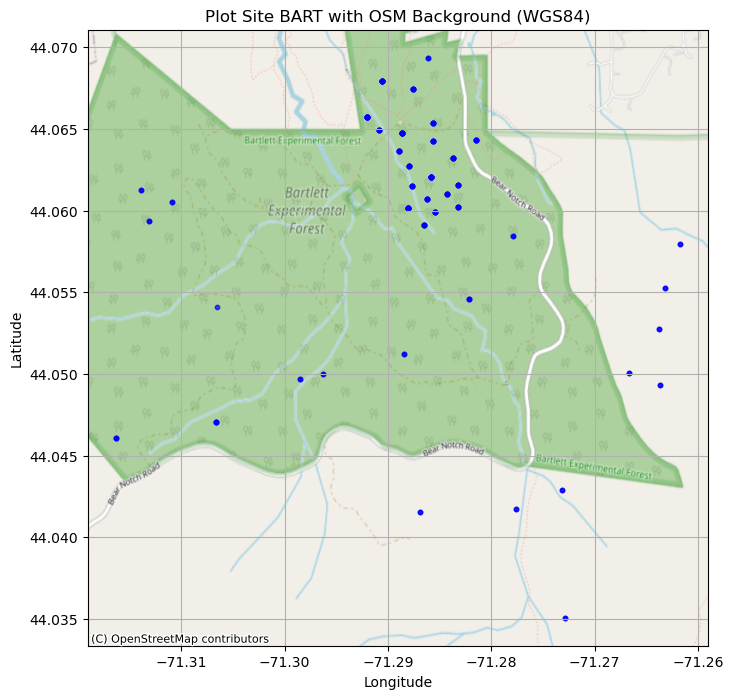

In [7]:
plot_vst_perplotperyear()

### Process Important Data

In [8]:
def process_sub_dirs(base_dir):
    sub_dirs = [entry.path for entry in os.scandir(base_dir) if entry.is_dir()]
    df_mappingandtagging = []
    df_apparentindividual = []
    
    for sub_dir in sub_dirs:
        csv_files = [f for f in os.listdir(sub_dir) if f.endswith('.csv')]
        has_apparentindividual = False
        has_mappingandtagging = False
        
        for csv_file in csv_files:
            if 'apparentindividual' in csv_file:
                df = pd.read_csv(os.path.join(sub_dir, csv_file))
                df_apparentindividual.append(df)
                has_apparentindividual = True
            elif 'mappingandtagging' in csv_file:
                df = pd.read_csv(os.path.join(sub_dir, csv_file))
                df_mappingandtagging.append(df)
                has_mappingandtagging = True
        
        if not has_apparentindividual:
            print(f"No 'apparentindividual' file in {sub_dir}")
        if not has_mappingandtagging:
            print(f"No 'mappingandtagging' file in {sub_dir}")

    df_apparentindividual_combined = pd.concat(df_apparentindividual, ignore_index=True) if df_apparentindividual else None
    df_mappingandtagging_combined = pd.concat(df_mappingandtagging, ignore_index=True) if df_mappingandtagging else None
    print("*** 'mappingandtagging' processing done ***")
    display_missing_values_info(df_mappingandtagging_combined)
    print("*** 'apparentindividual' processing done ***")
    display_missing_values_info(df_apparentindividual_combined)

    return df_apparentindividual_combined, df_mappingandtagging_combined

In [9]:
df_apparentindividual_combined, df_mappingandtagging_combined = process_sub_dirs(SITE_IMAGE_DIR)

No 'apparentindividual' file in data/NEON/BART/NEON_struct-plant/NEON.D01.BART.DP1.10098.001.2014-08.basic.20250129T000730Z.RELEASE-2025
No 'apparentindividual' file in data/NEON/BART/NEON_struct-plant/NEON.D01.BART.DP1.10098.001.2018-07.basic.20250129T000730Z.RELEASE-2025
No 'apparentindividual' file in data/NEON/BART/NEON_struct-plant/NEON.D01.BART.DP1.10098.001.2019-07.basic.20250129T000730Z.RELEASE-2025
No 'apparentindividual' file in data/NEON/BART/NEON_struct-plant/NEON.D01.BART.DP1.10098.001.2021-07.basic.20250129T000730Z.RELEASE-2025
No 'apparentindividual' file in data/NEON/BART/NEON_struct-plant/NEON.D01.BART.DP1.10098.001.2022-07.basic.20250129T000730Z.RELEASE-2025
*** 'mappingandtagging' processing done ***
shape: (173124, 31)
Missing values and unique counts in the specified columns:
- uid             : 0          missing values, 6414       unique values
- namedLocation   : 0          missing values, 41         unique values
- date            : 0          missing values, 2

,0,1,2,3,4,...,173119,173120,173121,173122,173123
uid,779a09fb-be9a-4dbc-8d9a-73e139d30983,020028a9-efd3-4172-9a99-e459bbdf3e94,840c9429-789b-4828-b583-ee7f0c2534a5,936755d2-751d-4ecd-a877-605698cb0f19,52aa1c74-8545-4f7f-ac16-07eca6f5ade2,...,871418f2-9761-420f-9074-5814818efed3,0f790d2e-f446-43d3-9a86-6d6f1a47bc47,1968b52e-d03a-4b54-9221-b9ab462f7ce3,a0f33f7f-6b39-4083-93e6-7d9f516df96c,3c7f4e50-b484-4623-8692-8da52125147d
namedLocation,BART_012.basePlot.vst,BART_012.basePlot.vst,BART_012.basePlot.vst,BART_012.basePlot.vst,BART_012.basePlot.vst,...,BART_034.basePlot.vst,BART_034.basePlot.vst,BART_034.basePlot.vst,BART_041.basePlot.vst,BART_041.basePlot.vst
date,2014-08-05,2014-08-05,2014-08-05,2014-08-05,2014-08-05,...,2024-10-03,2024-10-03,2024-10-03,2024-10-03,2024-10-03
eventID,vst_BART_2014,vst_BART_2014,vst_BART_2014,vst_BART_2014,vst_BART_2014,...,vst_BART_2024,vst_BART_2024,vst_BART_2024,vst_BART_2024,vst_BART_2024
domainID,D01,D01,D01,D01,D01,...,D01,D01,D01,D01,D01
siteID,BART,BART,BART,BART,BART,...,BART,BART,BART,BART,BART
plotID,BART_012,BART_012,BART_012,BART_012,BART_012,...,BART_034,BART_034,BART_034,BART_041,BART_041
pointID,NaN,NaN,NaN,31.0,NaN,...,61.0,61.0,41.0,NaN,25.0
stemDistance,NaN,NaN,NaN,5.1,NaN,...,12.6,9.7,9.7,NaN,11.5
stemAzimuth,NaN,NaN,NaN,82.2,NaN,...,217.8,193.9,37.2,NaN,304.2


*** 'apparentindividual' processing done ***
shape: (21004, 41)
Missing values and unique counts in the specified columns:
- uid             : 0          missing values, 21004      unique values
- namedLocation   : 0          missing values, 41         unique values
- date            : 0          missing values, 109        unique values
- eventID         : 0          missing values, 9          unique values
- domainID        : 0          missing values, 1          unique values
- siteID          : 0          missing values, 1          unique values
- plotID          : 0          missing values, 41         unique values
- subplotID       : 0          missing values, 60         unique values
- individualID    : 0          missing values, 5437       unique values
- tempStemID      : 16480      missing values, 4          unique values
- tagStatus       : 3159       missing values, 7          unique values
- growthForm      : 1077       missing values, 6          unique values
- plantStatus

,0,1,2,3,4,...,20999,21000,21001,21002,21003
uid,9fc4152c-1cbb-492a-88dc-6872534c8a17,4549b2b0-5e1f-4a35-996b-4f0c640987a8,3ee89cda-67ed-495f-b59b-7251375438e1,a509d71e-05a1-4d1d-bd39-dedb3dd5313a,a66424d4-d733-4fa1-8324-52d0e532931d,...,5179d163-e05a-4a4e-b2c1-1df78042d828,727fb493-6548-41ac-a411-ab311afb8841,a3745493-14f2-487a-842c-29f258d6fdfd,18e684d1-0556-4ce9-b1ca-743f08f7e8a6,09ed02f5-2c56-4bcc-9a9d-50cff538b3d1
namedLocation,BART_044.basePlot.vst,BART_044.basePlot.vst,BART_044.basePlot.vst,BART_044.basePlot.vst,BART_037.basePlot.vst,...,BART_073.basePlot.vst,BART_073.basePlot.vst,BART_073.basePlot.vst,BART_073.basePlot.vst,BART_073.basePlot.vst
date,2015-08-26,2015-08-26,2015-08-26,2015-08-26,2015-08-26,...,2023-10-18,2023-10-18,2023-10-18,2023-10-18,2023-10-18
eventID,vst_BART_2015,vst_BART_2015,vst_BART_2015,vst_BART_2015,vst_BART_2015,...,vst_BART_2023,vst_BART_2023,vst_BART_2023,vst_BART_2023,vst_BART_2023
domainID,D01,D01,D01,D01,D01,...,D01,D01,D01,D01,D01
siteID,BART,BART,BART,BART,BART,...,BART,BART,BART,BART,BART
plotID,BART_044,BART_044,BART_044,BART_044,BART_037,...,BART_073,BART_073,BART_073,BART_073,BART_073
subplotID,33_100,39_400,39_400,39_100,41_400,...,39_400,23_400,39_400,48_25_3,33_25_4
individualID,NEON.PLA.D01.BART.05455,NEON.PLA.D01.BART.05443,NEON.PLA.D01.BART.05408,NEON.PLA.D01.BART.05309,NEON.PLA.D01.BART.05076,...,NEON.PLA.D01.BART.03951,NEON.PLA.D01.BART.03696,NEON.PLA.D01.BART.03958,NEON.PLA.D01.BART.04892,NEON.PLA.D01.BART.03903
tempStemID,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0


> They must have height and species! 

In [13]:
# HEY
df_mappingandtagging_filtered = df_mappingandtagging_combined.dropna(subset=['stemDistance', 'stemAzimuth', 'scientificName'])
# df_apparentindividual_filtered = df_apparentindividual_combined.dropna(subset=['height'])
df_apparentindividual_filtered = df_apparentindividual_combined

In [14]:
def merge_ai_mt():
    df_combined = pd.merge(
        df_apparentindividual_filtered,
        df_mappingandtagging_filtered,
        on='individualID',
        how='left',
        suffixes=('', '_drop')
    ).filter(regex='^(?!.*_drop)')
    df_combined = df_combined.dropna(subset=['stemDistance', 'stemAzimuth'])
    df_combined = df_combined.drop_duplicates(subset=['uid'])
    df_combined_filtered = df_combined[
        ['uid', 'namedLocation', 'date', 'eventID', 'domainID', 'siteID',
        'plotID', 'pointID', 'stemDistance', 'stemAzimuth', 
        'individualID', 'taxonID', 'scientificName', 'genus',
        'family', 'taxonRank', 'subplotID', 'tempStemID',
        'tagStatus', 'growthForm', 'plantStatus', 'stemDiameter',
        'height', 'maxCrownDiameter', 'ninetyCrownDiameter', 'canopyPosition']
    ]
    print("*** Merge height and genus processing done ***")
    display_missing_values_info(df_combined_filtered)
    return df_combined_filtered


In [15]:
df_combined_filtered = merge_ai_mt()

*** Merge height and genus processing done ***
shape: (8594, 26)
Missing values and unique counts in the specified columns:
- uid             : 0          missing values, 8594       unique values
- namedLocation   : 0          missing values, 41         unique values
- date            : 0          missing values, 109        unique values
- eventID         : 0          missing values, 9          unique values
- domainID        : 0          missing values, 1          unique values
- siteID          : 0          missing values, 1          unique values
- plotID          : 0          missing values, 41         unique values
- pointID         : 4          missing values, 16         unique values
- stemDistance    : 0          missing values, 295        unique values
- stemAzimuth     : 0          missing values, 1548       unique values
- individualID    : 0          missing values, 2037       unique values
- taxonID         : 0          missing values, 28         unique values
- scientific

,1,28,56,83,110,...,245499,245526,245553,245580,245607
uid,4549b2b0-5e1f-4a35-996b-4f0c640987a8,3ee89cda-67ed-495f-b59b-7251375438e1,a66424d4-d733-4fa1-8324-52d0e532931d,f0cefda6-845e-403d-8d36-5b704dfa0479,57712bd9-ca7b-4cf6-aac7-4cb658e27d47,...,9aefd3bf-08cc-4c36-9d3d-763444a656d5,cb71732b-660d-4443-b68d-630b8be061dd,5179d163-e05a-4a4e-b2c1-1df78042d828,727fb493-6548-41ac-a411-ab311afb8841,a3745493-14f2-487a-842c-29f258d6fdfd
namedLocation,BART_044.basePlot.vst,BART_044.basePlot.vst,BART_037.basePlot.vst,BART_044.basePlot.vst,BART_037.basePlot.vst,...,BART_073.basePlot.vst,BART_073.basePlot.vst,BART_073.basePlot.vst,BART_073.basePlot.vst,BART_073.basePlot.vst
date,2015-08-26,2015-08-26,2015-08-26,2015-08-26,2015-08-26,...,2023-10-18,2023-10-18,2023-10-18,2023-10-18,2023-10-18
eventID,vst_BART_2015,vst_BART_2015,vst_BART_2015,vst_BART_2015,vst_BART_2015,...,vst_BART_2023,vst_BART_2023,vst_BART_2023,vst_BART_2023,vst_BART_2023
domainID,D01,D01,D01,D01,D01,...,D01,D01,D01,D01,D01
siteID,BART,BART,BART,BART,BART,...,BART,BART,BART,BART,BART
plotID,BART_044,BART_044,BART_037,BART_044,BART_037,...,BART_073,BART_073,BART_073,BART_073,BART_073
pointID,57.0,41.0,41.0,57.0,61.0,...,43.0,23.0,41.0,23.0,57.0
stemDistance,19.0,8.8,4.9,11.9,6.1,...,13.3,4.0,14.4,11.8,4.8
stemAzimuth,93.0,301.8,75.6,100.8,186.4,...,267.9,60.8,315.7,16.0,103.5


In [16]:
def merge_vst_perplotperyear():
    df_all_unique = df_vst_perplotperyear.drop_duplicates(subset=['plotID'])
    df_combined_georeferenced = pd.merge(
        df_combined_filtered,
        df_all_unique[['plotID', 'decimalLatitude', 'decimalLongitude','easting','northing']],
        on='plotID',
        how='left'
    )
    print("*** Merge vst_perplotperyear processing done ***")
    return df_combined_georeferenced

In [17]:
df_combined_georeferenced = merge_vst_perplotperyear()

*** Merge vst_perplotperyear processing done ***


In [18]:
def pol2latlon(lat, lon, distance, azimuth):
    R = 6378137
    # lat, lon: 度
    # distance: 米
    # azimuth: 度，0为正北，顺时针
    lat1 = np.deg2rad(lat)
    lon1 = np.deg2rad(lon)
    az = np.deg2rad(azimuth)
    d = distance

    lat2 = np.arcsin(np.sin(lat1)*np.cos(d/R) + np.cos(lat1)*np.sin(d/R)*np.cos(az))
    lon2 = lon1 + np.arctan2(np.sin(az)*np.sin(d/R)*np.cos(lat1), np.cos(d/R)-np.sin(lat1)*np.sin(lat2))
    return np.rad2deg(lat2), np.rad2deg(lon2)

def add_tree_lat_lon(df):
    # 计算每棵树的经纬度
    lat, lon = pol2latlon(
        df['decimalLatitude'].astype(float).values,
        df['decimalLongitude'].astype(float).values,
        df['stemDistance'].astype(float).values,
        df['stemAzimuth'].astype(float).values
    )
    df['tree_lat'] = lat
    df['tree_lon'] = lon
    
    # 计算每棵树的easting和northing
    easting, northing = df['easting'].values, df['northing'].values
    tree_easting = easting + df['stemDistance'].astype(float).values * np.sin(np.deg2rad(df['stemAzimuth'].astype(float).values))
    tree_northing = northing + df['stemDistance'].astype(float).values * np.cos(np.deg2rad(df['stemAzimuth'].astype(float).values))
    
    df['tree_easting'] = tree_easting
    df['tree_northing'] = tree_northing
    print("*** Add tree lat and lon processing done ***")


In [19]:
add_tree_lat_lon(df_combined_georeferenced)

*** Add tree lat and lon processing done ***


In [20]:
df_combined_georeferenced_sorted = df_combined_georeferenced.sort_values(by='date', ascending=False)
df_combined_georeferenced_unique = df_combined_georeferenced_sorted.drop_duplicates(subset=['tree_lat', 'tree_lon'])
df_combined_georeferenced = df_combined_georeferenced_unique
print("*** Drop duplicate tree lat and lon processing done ***")
print("*** Useful points: valid genus but some nan in height ***")
display_missing_values_info(df_combined_georeferenced)

*** Drop duplicate tree lat and lon processing done ***
*** Useful points: valid genus but some nan in height ***
shape: (2025, 34)
Missing values and unique counts in the specified columns:
- uid             : 0          missing values, 2025       unique values
- namedLocation   : 0          missing values, 41         unique values
- date            : 0          missing values, 70         unique values
- eventID         : 0          missing values, 9          unique values
- domainID        : 0          missing values, 1          unique values
- siteID          : 0          missing values, 1          unique values
- plotID          : 0          missing values, 41         unique values
- pointID         : 2          missing values, 16         unique values
- stemDistance    : 0          missing values, 295        unique values
- stemAzimuth     : 0          missing values, 1548       unique values
- individualID    : 0          missing values, 2025       unique values
- taxonID        

,8593,8554,8535,8536,8537,...,2382,2388,1260,286,212
uid,a3745493-14f2-487a-842c-29f258d6fdfd,13eff679-ecbf-4030-a8b0-48100174871a,fdc1a323-fde1-4a0d-a7b5-bdfc6cb83b4d,89250981-8f10-4049-9afa-b8b3434b5b8e,ff5b665d-c59f-4842-974e-90ccb985ad40,...,ac02a9e3-611a-464c-8d61-60b64c6c592f,15b83fc2-aff5-43c3-a31d-962b09fc65a8,ee163e37-133b-408e-9e5f-a3bf9d8788b8,007a9f1a-8718-408a-b4ec-f330d2fe8917,b5f4e7c8-38ab-4276-a300-66e176ae1bc4
namedLocation,BART_073.basePlot.vst,BART_073.basePlot.vst,BART_073.basePlot.vst,BART_073.basePlot.vst,BART_073.basePlot.vst,...,BART_028.basePlot.vst,BART_028.basePlot.vst,BART_073.basePlot.vst,BART_042.basePlot.vst,BART_073.basePlot.vst
date,2023-10-18,2023-10-18,2023-10-18,2023-10-18,2023-10-18,...,2016-09-14,2016-09-14,2016-08-02,2015-08-31,2015-08-27
eventID,vst_BART_2023,vst_BART_2023,vst_BART_2023,vst_BART_2023,vst_BART_2023,...,vst_BART_2016,vst_BART_2016,vst_BART_2016,vst_BART_2015,vst_BART_2015
domainID,D01,D01,D01,D01,D01,...,D01,D01,D01,D01,D01
siteID,BART,BART,BART,BART,BART,...,BART,BART,BART,BART,BART
plotID,BART_073,BART_073,BART_073,BART_073,BART_073,...,BART_028,BART_028,BART_073,BART_042,BART_073
pointID,57.0,41.0,41.0,39.0,41.0,...,41.0,41.0,41.0,57.0,57.0
stemDistance,4.8,9.7,13.8,5.3,9.4,...,2.2,13.5,4.5,9.9,9.6
stemAzimuth,103.5,328.1,282.1,71.0,296.4,...,247.3,134.8,305.4,142.1,121.5


Easting range: 314424.89 m ~ 318850.75 m
Northing range: 4878260.43 m ~ 4882127.60 m
Area dimensions: 4425.85 m × 3867.17 m


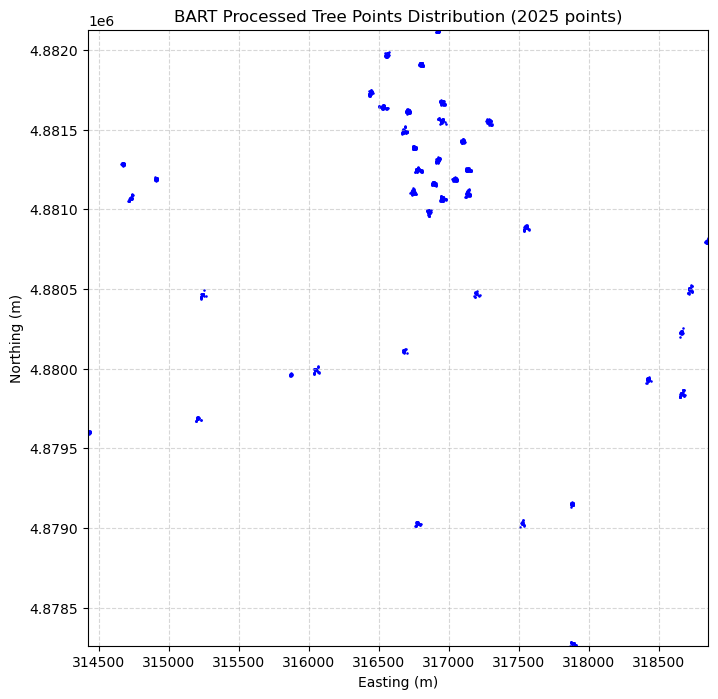

In [21]:
def plot_and_save_tree_distribution(df):
    # Plot all points with x and y axis labeled with coordinates
    plt.figure(figsize=(8, 8))
    plt.scatter(df['tree_easting'], df['tree_northing'], s=0.7, alpha=1, color='blue')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    plt.title(f'{SITE_CODE} Processed Tree Points Distribution ({len(df)} points)')

    # Calculate and print the coordinate distribution range and dimensions
    easting_min, easting_max = df['tree_easting'].min(), df['tree_easting'].max()
    northing_min, northing_max = df['tree_northing'].min(), df['tree_northing'].max()
    print(f"Easting range: {easting_min:.2f} m ~ {easting_max:.2f} m")
    print(f"Northing range: {northing_min:.2f} m ~ {northing_max:.2f} m")

    width_m = easting_max - easting_min
    height_m = northing_max - northing_min
    print(f"Area dimensions: {width_m:.2f} m × {height_m:.2f} m")

    plt.xlim(easting_min, easting_max)
    plt.ylim(northing_min, northing_max)
    plt.grid(True, linestyle='--', alpha=0.5)
    filename=f'{SITE_CODE}_processed_tree_distribution.png'
    plt.savefig(os.path.join(PLOT_DIR, filename))
    plt.show()

# Example usage
plot_and_save_tree_distribution(df_combined_georeferenced)


### For Biomass

In [29]:
# BYE
# Write the wood density data to a JSON file
wood_density = {
    'Fagus grandifolia Ehrh.': 0.62,  # 美洲山毛榉
    'Tsuga canadensis (L.) Carrière': 0.38,  # 加拿大铁杉
    'Betula alleghaniensis Britton': 0.55,  # 黄桦
    'Acer rubrum L.': 0.54,  # 红枫
    'Betula papyrifera Marshall var. papyrifera': 0.51,  # 白桦（纸皮桦）主变种
    'Betula papyrifera Marshall': 0.51,  # 白桦
    'Picea rubens Sarg.': 0.40,  # 红云杉
    'Fraxinus americana L.': 0.60,  # 白蜡树
    'Abies balsamea (L.) Mill.': 0.37,  # 香脂冷杉
    'Acer saccharum Marshall var. saccharum': 0.63,  # 糖枫主变种
    'Betula papyrifera Marshall var. cordifolia (Regel) Fernald': 0.51,  # 白桦变种
    'Fraxinus pennsylvanica Marshall': 0.60,  # 绿灰木
    'Ostrya virginiana (Mill.) K. Koch': 0.77,  # 美洲铁木
    'Pinus resinosa Aiton': 0.43,  # 红松
    'Pinus strobus L.': 0.35,  # 东部白松
    'Populus grandidentata Michx.': 0.38,  # 大齿杨
    'Acer pensylvanicum L.': 0.49,  # 条纹枫
    'Unknown plant': 0.55,  # 用平均值
    'Betula ×caerulea Blanch. var. caerulea': 0.53,  # 杂交桦
    'Betula populifolia Marshall': 0.50,  # 灰桦
    'Prunus pensylvanica L. f. var. pensylvanica': 0.50,  # 宾州樱
    'Prunus pensylvanica L. f.': 0.50,  # 宾州樱
    'Populus tremuloides Michx.': 0.37,  # 美国山杨
    'Quercus rubra L.': 0.68,  # 红橡
    'Viburnum lantanoides Michx.': 0.54,  # 绒毛荚蒾（灌木，估算）
    'Tilia americana L.': 0.37,  # 美洲椴
    'Ulmus americana L.': 0.52,  # 美洲榆
    'Acer saccharum Marshall': 0.63,  # 糖枫
}

with open('data/NEON/wood_density.json', 'w') as json_file:
    json.dump(wood_density, json_file, ensure_ascii=False, indent=4)

In [34]:
# HEY
default_density = 0.55
df_biomass = df_combined_georeferenced.copy()
unique_scientific_names = df_biomass['scientificName'].unique()

with open('data/NEON/wood_density.json', 'r') as json_file:
    wood_density = json.load(json_file)

# Find scientific names that are not in the wood_density dictionary
missing_species = [name for name in unique_scientific_names if name not in wood_density]

# Print out the scientific names that are not in wood_density
print("*** Processing biomass ***")
print("Species without wood density(using default density):")
for species in missing_species:
    print(f"- {species}")


*** Processing biomass ***
Species without wood density(using default density):


In [35]:
# HEY
def calc_biomass(row):
    dbh = row['stemDiameter']
    height = row['height']
    species = row['scientificName']
    density = wood_density.get(species, default_density)
    if np.isnan(dbh) or np.isnan(height):
        return np.nan
    agb = 0.0673 * (density * (dbh ** 2) * height) ** 0.976
    return agb

df_biomass['biomass'] = df_biomass.apply(calc_biomass, axis=1)
print("*** Biomass processing done ***")

In [39]:
# HEY
df_combined_georeferenced = df_biomass
print("=======")
print("*** Data processing done ***")
print(f"*** Non-NaN Count for Key Columns (all coordiantes are valid), total points: {len(df_combined_georeferenced)} ***")
columns_to_check = ['scientificName', 'genus', 'height', 'biomass', 'stemDiameter']
for column in columns_to_check:
    non_nan_count = df_combined_georeferenced[column].notna().sum()
    print(f"- {column}: {non_nan_count} valid values")
print("=======")

*** Data processing done ***
*** Non-NaN Count for Key Columns (all coordiantes are valid), total points: 2025 ***
- scientificName: 2025 valid values
- genus: 2022 valid values
- height: 1850 valid values
- biomass: 1850 valid values
- stemDiameter: 1857 valid values


### Visualize all points

In [40]:
def check_res(df):
    # 计算中心点
    center_lat = df['tree_lat'].mean()
    center_lon = df['tree_lon'].mean()

    # 将树的经纬度转换为GeoDataFrame
    geometry = [Point(xy) for xy in zip(df['tree_lon'], df['tree_lat'])]
    gdf_trees = gpd.GeoDataFrame(df, geometry=geometry)

    # 计算整个区域的bounding box
    min_lat, max_lat = df['tree_lat'].min(), df['tree_lat'].max()
    min_lon, max_lon = df['tree_lon'].min(), df['tree_lon'].max()

    # 创建folium地图
    m = folium.Map(location=[center_lat, center_lon], zoom_start=15, tiles='OpenStreetMap', max_zoom=22)

    # 添加整个区域的bounding box到地图
    folium.Rectangle(
        bounds=[[min_lat, min_lon], [max_lat, max_lon]],
        color='red',
        fill=True,
        fill_opacity=0
    ).add_to(m)

    # 计算10m的grid
    lat_grid_offset = 60 / 111000
    lon_grid_offset = 60 / (111000 * abs(math.cos(math.radians(center_lat))))

    # 绘制10m的grid
    lat_lines = int((max_lat - min_lat) / lat_grid_offset)
    lon_lines = int((max_lon - min_lon) / lon_grid_offset)

    for i in range(lat_lines + 1):
        lat = min_lat + i * lat_grid_offset
        folium.PolyLine(
            locations=[(lat, min_lon), (lat, max_lon)],
            color='green',
            weight=0.1,
            opacity=0.5
        ).add_to(m)

    for j in range(lon_lines + 1):
        lon = min_lon + j * lon_grid_offset
        folium.PolyLine(
            locations=[(min_lat, lon), (max_lat, lon)],
            color='green',
            weight=0.1,
            opacity=0.5
        ).add_to(m)

    # 筛选出在整个区域内的树点
    gdf_trees_in_area = gdf_trees.cx[min_lon:max_lon, min_lat:max_lat]

    # 随机选择500个树点
    sampled_geometries = random.sample(list(gdf_trees_in_area.geometry), min(500, len(gdf_trees_in_area)))

    # tqdm集成到循环
    for geom, row in tqdm(zip(sampled_geometries, gdf_trees_in_area.itertuples()), total=len(sampled_geometries), desc='Adding tree points'):
        folium.CircleMarker(
            location=[row.tree_lat, row.tree_lon],
            radius=5,  # Small radius to represent a point
            color='yellow',  # Color of the point
            fill=True,
            fill_opacity=1,
            popup=f"Lat: {row.tree_lat}, Lon: {row.tree_lon}, Genus: {row.genus}"  # Popup with tree_lat, tree_lon, genus
        ).add_to(m)
    m.save(os.path.join(PLOT_DIR, f'{SITE_CODE}_tree_distribution.html'))
    # 显示地图
    print(f'*** {SITE_CODE} tree distribution map saved to {PLOT_DIR} ***')
    return m

m = check_res(df_combined_georeferenced)
m

 ... (more hidden) ...


*** BART tree distribution map saved to data/NEON/BART/BART_plots ***


In [45]:
# HEY
genus_unique = df_combined_georeferenced['genus'].dropna().unique()
genus_unique_sorted = sorted(genus_unique)
genus_encoding = {genus: idx + 1 for idx, genus in enumerate(genus_unique_sorted)}
print(f"*** Start generating patch tiles, total {len(genus_encoding)} genus ***")

*** Start generating patch tiles, total 15 genus ***


In [46]:
# HEY
def generate_patch_tiles(df, genus_encoding, patch_dir, site_code,
                         patch_size=100, stride=100, resolution=1, crs='EPSG:32618'):

    # filter valid points
    df_valid = df.dropna(subset=['tree_easting', 'tree_northing', 'height', 'genus', 'biomass'])
    # compute global extents
    min_e, max_e = df_valid['tree_easting'].min(), df_valid['tree_easting'].max()
    min_n, max_n = df_valid['tree_northing'].min(), df_valid['tree_northing'].max()

    patch_id = 0

    for x0 in tqdm(np.arange(min_e, max_e, stride), desc="Processing Easting"):
        for y0 in tqdm(np.arange(min_n, max_n, stride), desc="Processing Northing", leave=False):
            # select points in current window
            mask = (
                (df_valid['tree_easting'] >= x0) & (df_valid['tree_easting'] < x0 + patch_size) &
                (df_valid['tree_northing'] >= y0) & (df_valid['tree_northing'] < y0 + patch_size)
            )
            pts = df_valid[mask]
            if pts.empty:
                continue

            # initialize rasters
            height_arr = np.zeros((patch_size, patch_size), dtype=np.float32)
            genus_arr  = np.zeros((patch_size, patch_size), dtype=np.float32)
            biomass_arr = np.zeros((patch_size, patch_size), dtype=np.float32)
            # rasterize points
            for _, row in pts.iterrows():
                ix = int(row['tree_easting'] - x0)
                iy = int(row['tree_northing'] - y0)
                iy = patch_size - 1 - iy  # flip y for raster row index
                if 0 <= ix < patch_size and 0 <= iy < patch_size:
                    height_arr[iy, ix] = row['height']
                    genus_arr[iy, ix]  = genus_encoding[row['genus']]
                    biomass_arr[iy, ix] = row['biomass']

            # Mask invalid values
            height_arr = np.ma.masked_equal(height_arr, 0)
            genus_arr = np.ma.masked_equal(genus_arr, 0)
            biomass_arr = np.ma.masked_equal(biomass_arr, 0)

            # write GeoTIFF
            transform = from_origin(x0, y0 + patch_size, resolution, resolution)
            out_fp = os.path.join(patch_dir, f"patch_{patch_id:05d}.tif")
            with rasterio.open(
                out_fp, 'w',
                driver='GTiff',
                height=patch_size,
                width=patch_size,
                count=3,
                dtype=height_arr.dtype,
                crs=crs,
                transform=transform,
                nodata=0
            ) as dst:
                dst.write(height_arr.filled(0), 1)  # Use filled to write masked arrays
                dst.write(genus_arr.filled(0), 2)
                dst.write(biomass_arr.filled(0), 3)

            patch_id += 1
    print(f"*** {patch_id} patches saved to {patch_dir} ***")

    return patch_id

In [49]:
patch_id = generate_patch_tiles(df_combined_georeferenced, genus_encoding, PATCH_DIR, SITE_CODE)

 ... (more hidden) ...

*** 64 patches saved to data/NEON/BART/BART_patch ***


In [60]:
def plot_patch_tiles(patch_dir, start_patch_id=10, end_patch_id=19, figsize=(10, 10)):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=figsize)
    axes = axes.flatten()

    for i, patch_id in enumerate(range(start_patch_id, end_patch_id)):
        with rasterio.open(f'{patch_dir}/patch_{patch_id:05d}.tif') as src:
            band = src.read(1)
            # Mask out the zero values
            band = np.ma.masked_equal(band, 0)
            # Get the transform to calculate coordinates
            transform = src.transform
        ax = axes[i]
        cax = ax.imshow(band, cmap='viridis')
        ax.set_title(f'{SITE_CODE} Patch {patch_id:05d}')
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        # Calculate and display coordinates
        x_min, y_max = transform * (0, 0)
        x_max, y_min = transform * (band.shape[1], band.shape[0])
        ax.set_xlabel(f'X: {x_min:.1f} to {x_max:.1f}')
        ax.set_ylabel(f'Y: {y_min:.1f} to {y_max:.1f}')
        
        # Add 10m grid
        ax.set_xticks(np.arange(0, band.shape[1], 10))
        ax.set_yticks(np.arange(0, band.shape[0], 10))
        ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)

    # Create a new axis for the colorbar outside the main plot
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(cax, cax=cbar_ax, orientation='vertical', label='Height')
    fig.savefig(os.path.join(PLOT_DIR, f'{SITE_CODE}_patch_tiles.png'))
    print(f'*** {SITE_CODE} patch tiles saved to {PLOT_DIR} ***')
    plt.show()



*** BART patch tiles saved to data/NEON/BART/BART_plots ***


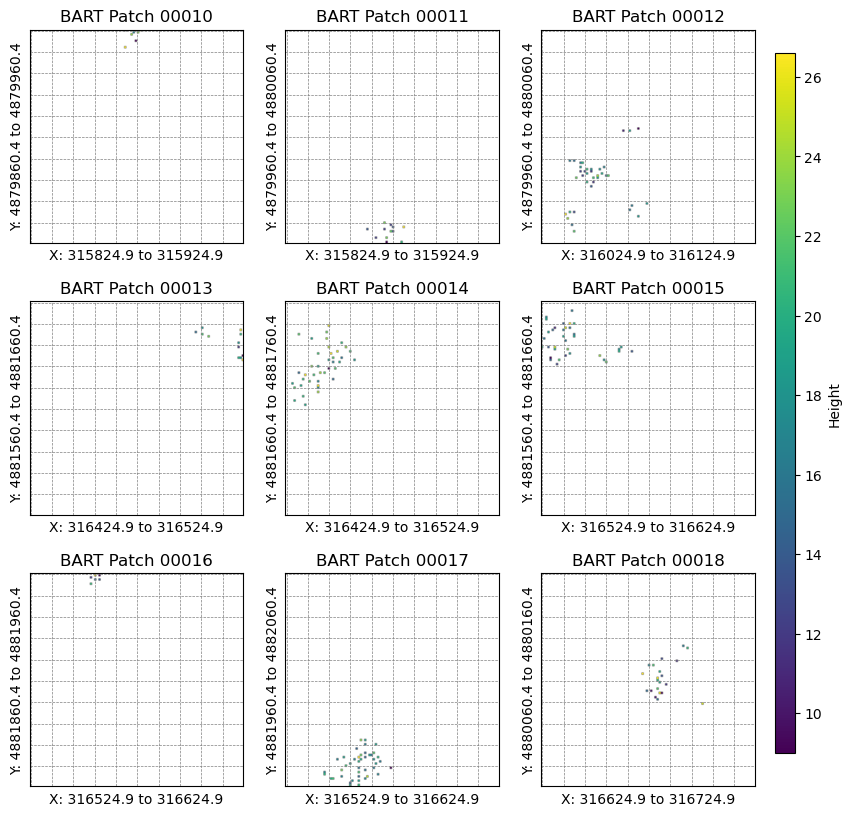

In [61]:
# Example usage
plot_patch_tiles(PATCH_DIR)

In [58]:
# HEY
def plot_patch_height_genus(
    patch_dir,
    genus_encoding,
    figsize=(25, 6),  # Adjusted to accommodate three plots
    grid_interval=10
):
    """
    可视化patch的height、genus和biomass三个波段，并加上10m网格和genus图例。

    参数:
        tif_path: str, patch tif文件路径
        genus_encoding: dict, genus编码到名称的映射，如 {1: 'Quercus', 2: 'Acer', ...}
        figsize: tuple, 图像大小
        grid_interval: int, 网格间隔（单位：像元）
    """
    file_path = os.path.join(patch_dir, "patch_00055.tif")
    with rasterio.open(file_path) as src:
        height = src.read(1)
        genus = src.read(2)
        biomass = src.read(3)
        
        # Mask out the zero values for better visualization
        height = np.ma.masked_equal(height, 0)
        genus = np.ma.masked_equal(genus, 0)
        biomass = np.ma.masked_equal(biomass, 0)
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
        
        # Plot height
        ax1 = axes[0]
        cax1 = ax1.imshow(height, cmap='viridis')
        ax1.set_title(f'Height {len(height)} points')
        fig.colorbar(cax1, ax=ax1, orientation='vertical', label='Height')
        ax1.set_xticks(np.arange(0, height.shape[1], grid_interval))
        ax1.set_yticks(np.arange(0, height.shape[0], grid_interval))
        ax1.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
        
        # Plot genus
        ax2 = axes[1]
        cax2 = ax2.imshow(genus, cmap='plasma')
        ax2.set_title(f'Genus {len(genus)} points')
        ax2.set_xticks(np.arange(0, genus.shape[1], grid_interval))
        ax2.set_yticks(np.arange(0, genus.shape[0], grid_interval))
        ax2.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
        
        # Create a legend for genus and place it beside the plot
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', label=genus_name,
                       markerfacecolor=plt.cm.plasma(i/len(genus_encoding)), markersize=10)
            for i, genus_name in enumerate(genus_encoding.keys())
        ]
        ax2.legend(handles=handles, title='Genus', loc='center left', bbox_to_anchor=(1, 0.5))
        
        # Plot biomass
        ax3 = axes[2]
        cax3 = ax3.imshow(biomass, cmap='inferno')
        ax3.set_title(f'Biomass {len(biomass)} points')
        fig.colorbar(cax3, ax=ax3, orientation='vertical', label='Biomass')
        ax3.set_xticks(np.arange(0, biomass.shape[1], grid_interval))
        ax3.set_yticks(np.arange(0, biomass.shape[0], grid_interval))
        ax3.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
        
        plt.savefig(os.path.join(PLOT_DIR, f'{SITE_CODE}_patch55_height_genus_biomass.png'))
        print(f'*** {SITE_CODE} patch55 height, genus, and biomass saved to {PLOT_DIR} ***')
        plt.tight_layout()
        plt.show()

*** BART patch55 height, genus, and biomass saved to data/NEON/BART/BART_plots ***


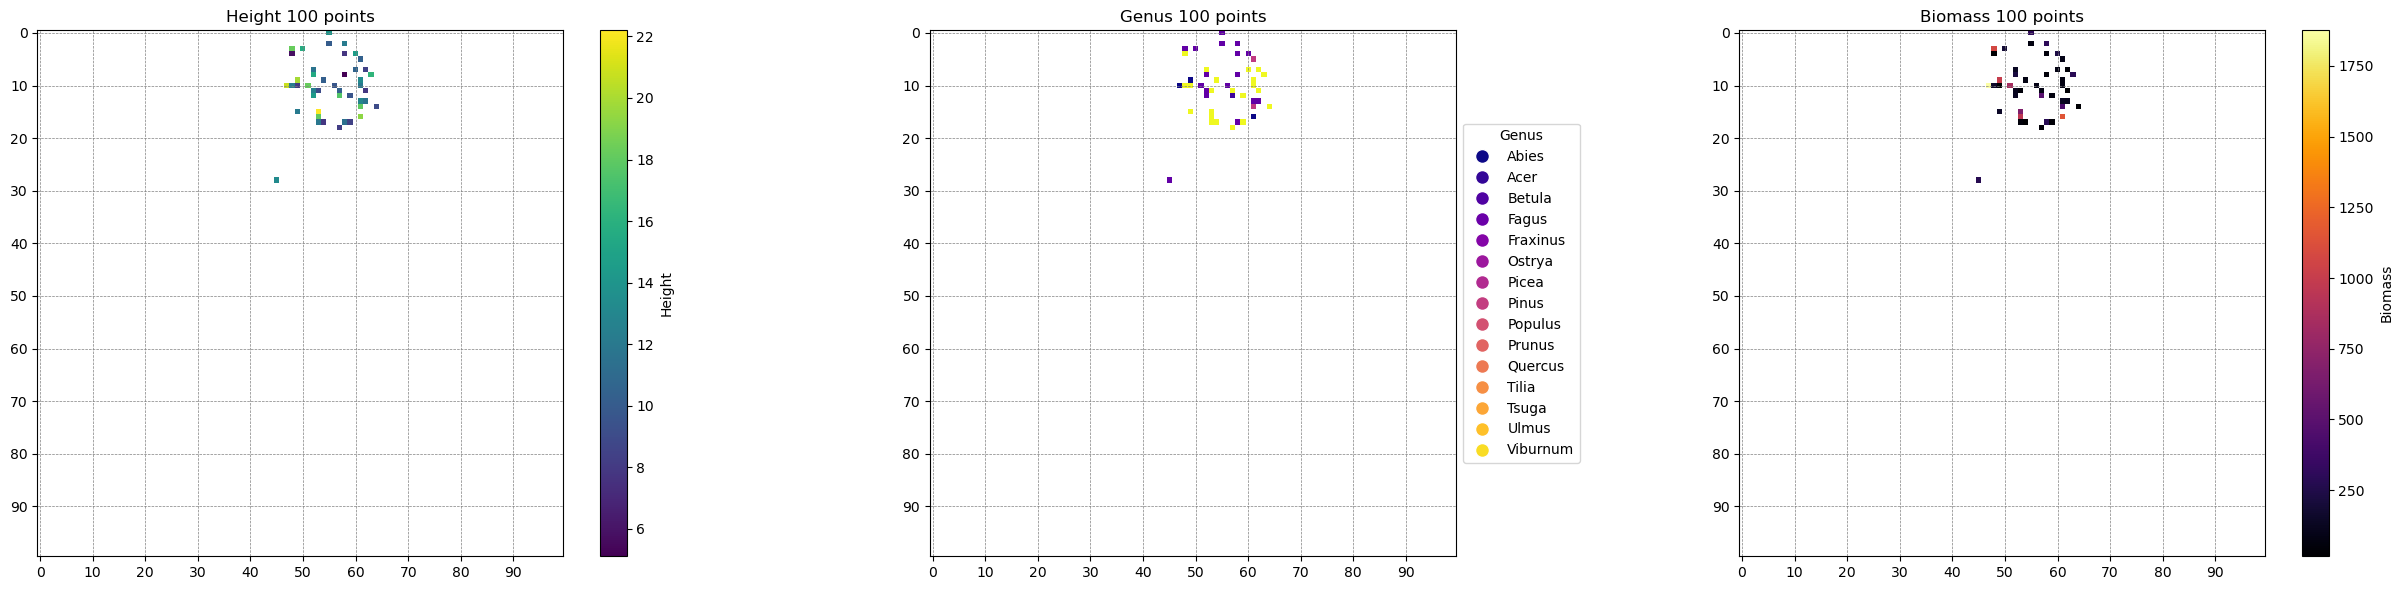

In [59]:
plot_patch_height_genus(PATCH_DIR, genus_encoding)
